This is going to have a lot stolen... I mean, borrowed from scanpy.

In [1]:
import pandas as pd
import numpy as np
import igraph as ig
import leidenalg as la
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import logging

from pathlib import Path
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
from numpy.random import default_rng
rng = np.random.default_rng()

In [3]:
sns.set(style='white', rc={'figure.figsize':(10,8)})

In [6]:
# Import our flow results
results = pd.read_csv(Path("../data/object_results.csv"))

In [7]:
# We want to remove some columns from any analysis.  At least for now.
ignore_columns = (
    "Object Id,XMin,XMax,YMin,YMax,Cell Area (µm²),"
    "Cytoplasm Area (µm²),Membrane Area (µm²),"
    "Nucleus Area (µm²),Nucleus Perimeter (µm),Nucleus Roundness"
)
flow_data = results.loc[:,~results.columns.isin(ignore_columns.split(","))]

Perform UMAP on the data:

In [8]:
umap_df = pd.DataFrame(
    data = umap.UMAP(
        n_neighbors  = 30,
        min_dist     = 0.1,
        n_components = 3,
        random_state = rng.integers(0,100),
    ).fit_transform(flow_data),
    columns = [
        "umap_1",
        "umap_2",
        "umap_3"
    ]
)

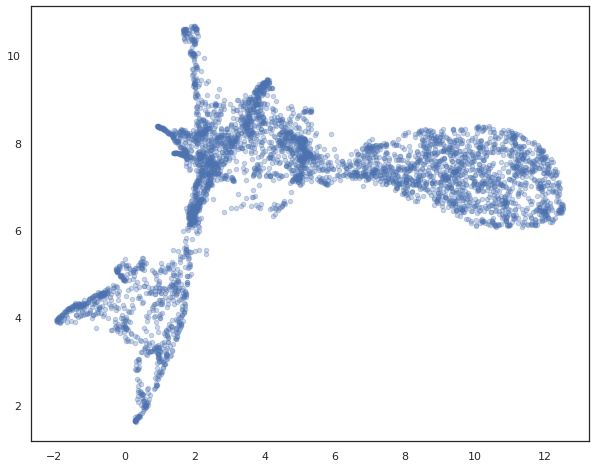

In [9]:
plt.scatter(
    x     = umap_df["umap_1"],
    y     = umap_df["umap_2"],
    s     = 20,
    alpha = 0.3,
    cmap  = 'Set1'
)

In [10]:
flow_data.columns

Index(['171Yb_Renin Cell Intensity', '175Lu_Aqu1 Cell Intensity',
       '176Yb_H3 Cell Intensity', '191Ir_DNA1 Cell Intensity',
       '193Ir_DNA2 Cell Intensity', '141Pr_aSMA Cell Intensity',
       '143Nd_Vimentin Cell Intensity', '145Nd_Aqu2 Cell Intensity',
       '146Nd_Nestin Cell Intensity', '147Sm_B-Cat Cell Intensity',
       '148Nd_Calbindin Cell Intensity', '150Nd_CD86 Cell Intensity',
       '151Eu_CD31 Cell Intensity', '152Sm_CD66b Cell Intensity',
       '153Eu_Uromodulin Cell Intensity', '156Gd_CD4 Cell Intensity',
       '159Tb_CD68 Cell Intensity', '161Dy_CD20 Cell Intensity',
       '162Dy_CD8a Cell Intensity', '164Dy_Cytokeratin7 Cell Intensity',
       '165Ho_Megalin Cell Intensity', '166Er_Col-IV Cell Intensity',
       '169Tm_WT1 Cell Intensity', '170Er_CD3 Cell Intensity',
       '89Y_CD45 Cell Intensity'],
      dtype='object')

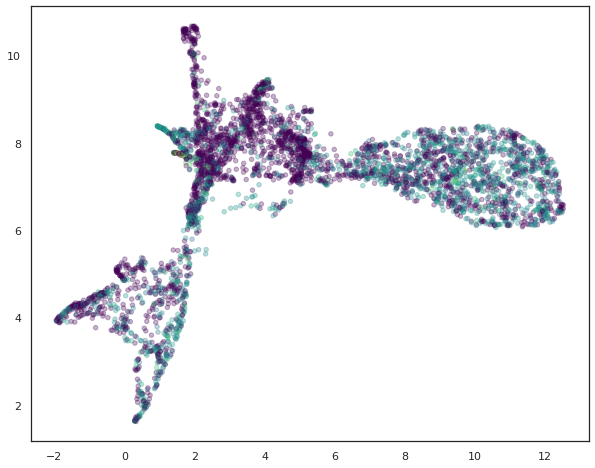

In [11]:
plt.scatter(
    x     = umap_df["umap_1"],
    y     = umap_df["umap_2"],
    s     = 20,
    alpha = 0.3,
    c     = np.log(results["162Dy_CD8a Cell Intensity"]+1),
    cmap  = 'viridis'
)
# transform the data into log-space because the differences are otherwise too great

There is *some* information we can potentially use in [Using UMAP for Clustering](https://umap-learn.readthedocs.io/en/latest/clustering.html).  Gonna try that:

First up, using simple *k*-means clustering:

In [12]:
import sklearn.cluster as cluster

In [13]:
kmeans_labels = cluster.KMeans(n_clusters=10).fit_predict(flow_data)

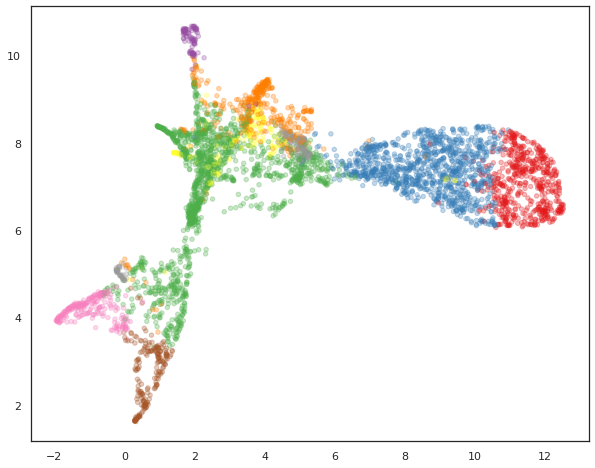

In [14]:
plt.scatter(
    x    = umap_df["umap_1"],
    y    = umap_df["umap_2"],
    s     = 20,
    alpha = 0.3,
    c    = kmeans_labels,
    cmap = 'Set1'
)

Not terrible, not great.

Alternatively, use a little more advanced algorithm, dbscan.
Cluster using the entire (25 component) dataset:

In [18]:
import hdbscan

In [19]:
hdbscan_labels = \
    hdbscan.HDBSCAN(
        min_samples      = 10,
        min_cluster_size = 500
    ).fit_predict(flow_data)

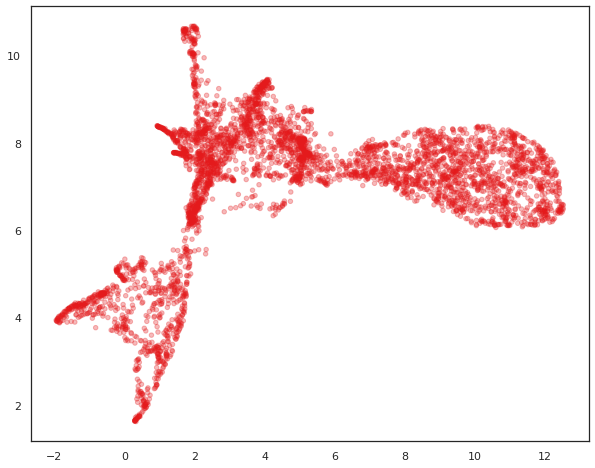

In [20]:
plt.scatter(
    x    = umap_df["umap_1"],
    y    = umap_df["umap_2"],
    s     = 20,
    alpha = 0.3,
    c    = hdbscan_labels,
    cmap = 'Set1'
)

That's junk.

Now cluster in low (2 UMAP components) dimensional space:

In [21]:
hdbscan_from_umap_labels = \
    hdbscan.HDBSCAN(
        min_samples      = 10,
        min_cluster_size = 500
    ).fit_predict(umap_df)

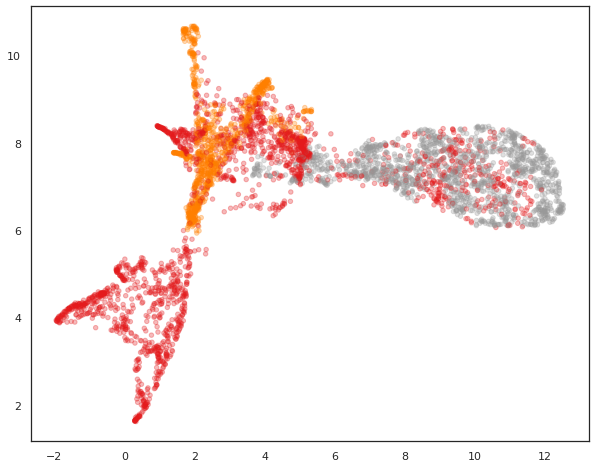

In [22]:
plt.scatter(
    x     = umap_df["umap_1"],
    y     = umap_df["umap_2"],
    s     = 20,
    alpha = 0.3,
    c     = hdbscan_from_umap_labels,
    cmap  = 'Set1'
)

Maybe less junk, but still not great.

In [23]:
pca_df = pd.DataFrame(
    PCA(
        n_components=10
    ).fit_transform(flow_data),
    columns = [
        [f"pc_{x}" for x in range(1,11)]
    ]
)

In [24]:
hdbscan_from_pca_labels = \
    hdbscan.HDBSCAN(
        min_samples      = 10,
        min_cluster_size = 500
    ).fit_predict(pca_df)

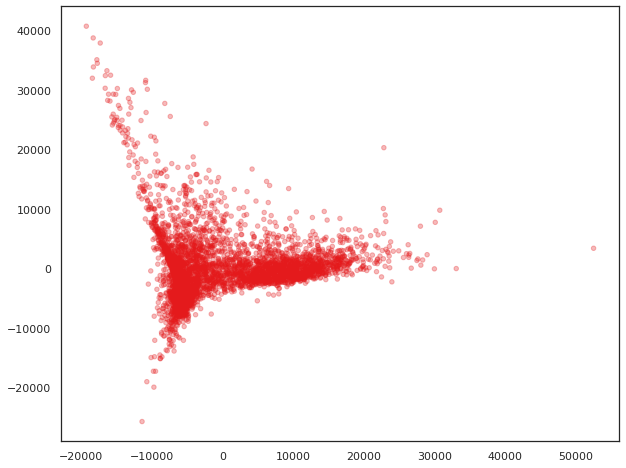

In [25]:
plt.scatter(
    x     = pca_df["pc_1"],
    y     = pca_df["pc_2"],
    s     = 20,
    alpha = 0.3,
    c     = hdbscan_from_pca_labels,
    cmap  = 'Set1'
)

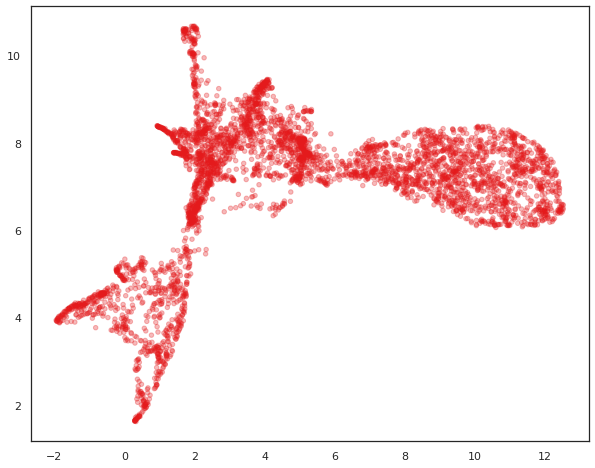

In [26]:
plt.scatter(
    x     = umap_df["umap_1"],
    y     = umap_df["umap_2"],
    s     = 20,
    alpha = 0.3,
    c     = hdbscan_from_pca_labels,
    cmap  = 'Set1'
)

Dug through the steps in scanpy used to perform Leiden-based community detection (working backwards):
* ```python
groups = np.array(part.membership)
```
* ```python
part = leidenalg.find_partition(g, partition_type, **partition_kwargs)
```
    * ```python
    partition_type = leidenalg.RBConfigurationVertexPartition
    ```
* ```python
g = scanpy._utils.get_igraph_from_adjacency(adjacency, directed=directed)
```
* ```python
adjacency = _utils._choose_graph(adata, obsp, neighbors_key)
```
* ```python
adjacency == _connectivities
```
* 
```python
_distances, _connectivities = 
    umap.umap_.fuzzy_simplicial_set(
        X            = scipy.sparse.coo_matrix(
                            ([], ([], [])),
                            shape=(df.shape[0], 1)
                        ),
        n_neighbors  = 15,
        random_state = rng.integers(0,100),
        metric       = "euclidean",
        knn_indices  = knn_indices,
        knn_dists    = knn_dists,
        )
```
* ```python
knn_indices, knn_distances, forest = \
        umap.umap_.nearest_neighbors(
            X,
            n_neighbors,
            random_state=random_state,
            metric=metric,
            metric_kwds=metric_kwds,
            angular=angular,
            verbose=verbose,
        )
```
    * Where `X` is the cell-by-analyte data to use

In [28]:
knn_indices, knn_distances, forest = \
      umap.umap_.nearest_neighbors(
          X            = flow_data,
          n_neighbors  = 30,
          random_state = rng.integers(0,100),
          metric       = 'euclidean',
          metric_kwds  = None,
          angular      = True,
          verbose      = True,
      )

Mon Feb  1 13:52:04 2021 Finding Nearest Neighbors
Mon Feb  1 13:52:04 2021 Building RP forest with 8 trees
Mon Feb  1 13:52:04 2021 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	Stopping threshold met -- exiting after 3 iterations
Mon Feb  1 13:52:04 2021 Finished Nearest Neighbor Search


In [29]:
# taken from scanpy._utils
def get_igraph_from_adjacency(adjacency, directed=None):
    """Get igraph graph from adjacency matrix."""

    sources, targets = adjacency.nonzero()
    weights = adjacency[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=directed)
    g.add_vertices(adjacency.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))
    try:
        g.es['weight'] = weights
    except:
        pass
    if g.vcount() != adjacency.shape[0]:
        logging.warning(
            f'The constructed graph has only {g.vcount()} nodes. '
            'Your adjacency matrix contained redundant nodes.'
        )
    return g

In [30]:
connectivities, sigmas, rhos, dists = \
  umap.umap_.fuzzy_simplicial_set(
    X            = scipy.sparse.coo_matrix(([], ([], [])),shape=(flow_data.shape[0], 1)),
    n_neighbors  = 30,
    random_state = rng.integers(0,100),
    metric       = "euclidean",
    knn_indices  = knn_indices,
    knn_dists    = knn_distances,
    return_dists = True,
  )

In [31]:
g = get_igraph_from_adjacency(connectivities, directed=False)

In [32]:
partition = la.find_partition(
    graph                = g, 
    partition_type       = la.RBConfigurationVertexPartition,
    resolution_parameter = 1.0
)

In [63]:
groups = np.array(partition.membership, dtype=int)

In [34]:
np.unique(groups)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

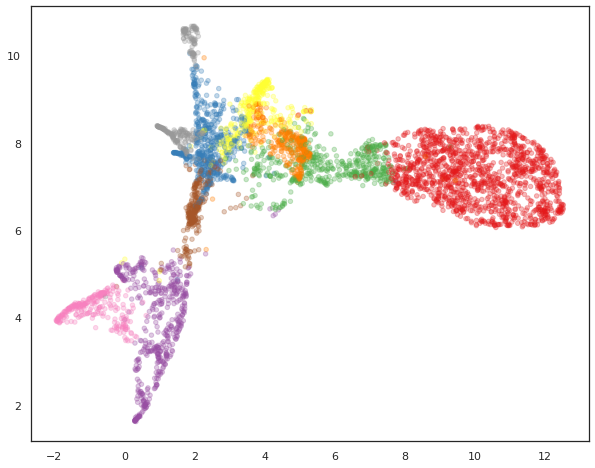

In [35]:
plt.scatter(
    x     = umap_df["umap_1"],
    y     = umap_df["umap_2"],
    s     = 20,
    alpha = 0.3,
    c     = groups,
    cmap  = 'Set1'
)

Well that looks promising.

In [58]:
np.save(file="../data/cluster_groups.npy", arr=groups)

In [67]:
np.savetxt(fname="../data/cluster_groups.txt", X=groups.astype(int), fmt='%i')

Let's try increasing the resolution:

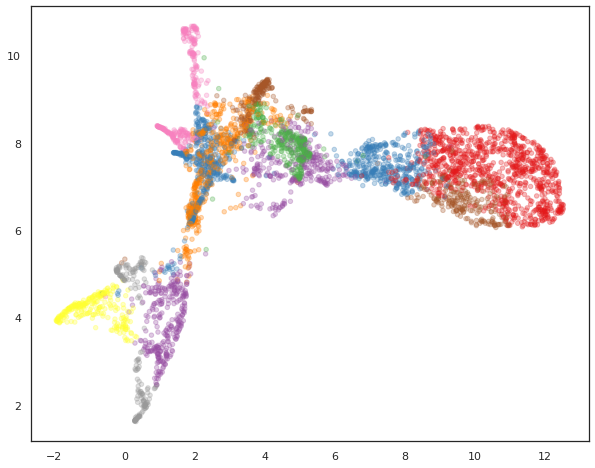

In [36]:
partition_1_5 = la.find_partition(
    graph                = g, 
    partition_type       = la.RBConfigurationVertexPartition,
    resolution_parameter = 1.5
)

groups_1_5 = np.array(partition_1_5.membership)

plt.scatter(
    x    = umap_df["umap_1"],
    y    = umap_df["umap_2"],
    s     = 20,
    alpha = 0.3,
    c    = groups_1_5,
    cmap = 'Set1'
)

Or let's go lower in resolution:

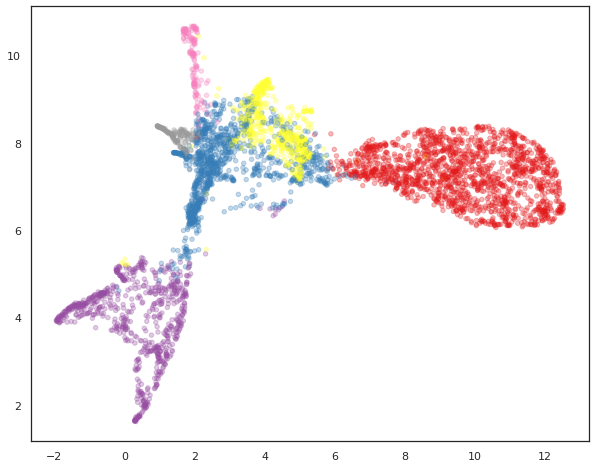

In [37]:
partition_0_5 = la.find_partition(
    graph                = g, 
    partition_type       = la.RBConfigurationVertexPartition,
    resolution_parameter = 0.5,
)

groups_0_5 = np.array(partition_0_5.membership)

plt.scatter(
    x     = umap_df["umap_1"],
    y     = umap_df["umap_2"],
    s     = 20,
    alpha = 0.3,
    c     = groups_0_5,
    cmap  = 'Set1'
)

Now, there is an alternative method included in the scanpy code:

In [38]:
from sklearn.metrics import pairwise_distances

In [39]:
dists = pairwise_distances(flow_data, metric='euclidean')

In [40]:
from umap.umap_ import nearest_neighbors

In [41]:
knn_indices, knn_dists, forest, *_ = nearest_neighbors(
    X            = dists,
    n_neighbors  = 30,
    random_state = rng.integers(0,100),
    metric       = 'euclidean',
    metric_kwds  = None,
    angular      = True,
    )

In [42]:
connectivities, sigmas, rhos, dists = \
  umap.umap_.fuzzy_simplicial_set(
    X            = scipy.sparse.coo_matrix(([], ([], [])),shape=(flow_data.shape[0], 1)),
    n_neighbors  = 30,
    random_state = rng.integers(0,100),
    metric       = "euclidean",
    knn_indices  = knn_indices,
    knn_dists    = knn_distances,
    return_dists = True,
  )

In [43]:
g = get_igraph_from_adjacency(connectivities, directed=False)

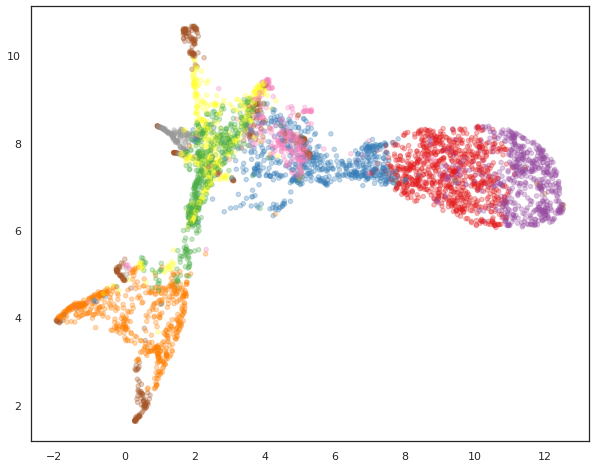

In [44]:
partition_alt = la.find_partition(
    graph                = g, 
    partition_type       = la.RBConfigurationVertexPartition,
    resolution_parameter = 0.6,
)

groups_alt = np.array(partition_alt.membership)

plt.scatter(
    x    = umap_df["umap_1"],
    y    = umap_df["umap_2"],
    s     = 20,
    alpha = 0.3,
    c    = groups_alt,
    cmap = 'Set1'
)

Using `sklearn.metric.pairwise_distances()` does not appear to match what is seen on UMAP very well.

In [56]:
np.save("../data/umap_connectvitities.npy", connectivities.todense())
flow_data.to_parquet("../data/flow_data.parquet", engine="fastparquet", compression=None)